# Workshop on Person verification in surveillance using feature extraction and learning

Course: Vision Systems

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/vision--systems/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective
In this workshop, we will perform the following four tasks
- Build a person verification model using feature extraction method 
- Build a machine learning model for person verification using siamese networks
- Apply the person verification model on a large dataset to find the most similar image given the query image

## Submission guideline

Once you finish the workshop, rename your .ipynb file to be your name, and submit your .ipynb file into LumiNUS.

## Dataset

- We will use *Labeled Faces in the Wild* (LFW) dataset, specifically, `All images aligned with deep funneling`, http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz (111 MB). More information can be found at the original dataset website at http://vis-www.cs.umass.edu/lfw/

## Note
- For demonstration purposes, we will only use a subset of the dataset in this workshop. The whole dataset contains 5749 persons (folders).
- To reduce the time required in model training in this workshop, we will build a simple convolutional neural network model.


In [ ]:
# Load library
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
print("PyTorch version is", torch.__version__)
# Use GPU if available else revert to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)


PyTorch version is 1.8.1+cu101
Device being used: cuda:0


In [ ]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path
# and change XXX to be your own folder. The pathname is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/VSE/person')
!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
archive    lfw-deepfunneled					 yao1.jpg
bill1.jpg  wk_person_verification_keras_v202107_reference.ipynb  yao2.jpg
data	   wk_person_verification_pytorch_v202107.ipynb


# Exercise 1: Evaluate similarity of two person image using HoG feature extraction method

Objective: Given two person images, extract their HoG features and calculate their cosine similarity (larger value indicates higher similarity)

The similarity of two images is 0.7275


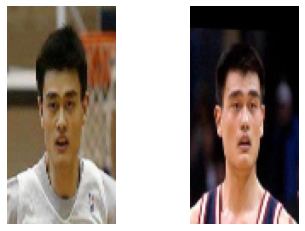

In [ ]:
# Define the configuration of HoG feature extraction

# Resize the input image to a fixed resolution for feature extraction
IMG_HEIGHT = 128
IMG_WIDTH = 64

# Block size, Cell size, Stride size, Number of bins as defined in HoG.
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

# Step 1: Load images and resize images
test_image1 = cv2.imread('yao2.jpg')
test_image2 = cv2.imread('yao1.jpg')

test_image1 = cv2.resize(test_image1, (IMG_WIDTH, IMG_HEIGHT))
test_image2 = cv2.resize(test_image2, (IMG_WIDTH, IMG_HEIGHT))

# Step 2: Extract HoG features
hog = cv2.HOGDescriptor((IMG_WIDTH, IMG_HEIGHT), blockSize, blockStride, cellSize, nbins)
test_image1_hog = hog.compute(test_image1)
test_image2_hog = hog.compute(test_image2)

# Step 3: Normalize the HoG features and calculate their cosine similarity distance
test_image1_hog = test_image1_hog/np.linalg.norm(test_image1_hog)
test_image2_hog = test_image2_hog/np.linalg.norm(test_image2_hog)

sims = np.inner(np.transpose(test_image1_hog), np.transpose(test_image2_hog))
print('The similarity of two images is %.4f' % sims)

# Display the input images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.show()


# Explore LFW face dataset

The dataset consists of folders corresponding to each person. The folder name is the name of the person.

First, we map each class (identity) to an integer id, and build mappings as dictionaries.
- mappings from person name (folder name) and class id: `name_to_classid` and `classid_to_name`

Furthermore, in each folder, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries
- mappings from imagepath and image id: `path_to_imageid` and `imageid_to_path`
- mappings from class id to image id: `classid_to_imageid` and `imageid_to_classid`

Summary 
- name: person name, folder name
- classid: integer number to indicate the person name
- path: path to save the person images
- imageid: integer number to indicate the image file index

In [ ]:
# Define the path for the downloaded images
PATH = "data/"
dirs = sorted(os.listdir(PATH))

# Build two dictionaries
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}

# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_imageid = {v: k for k, v in enumerate(all_images_path)}
imageid_to_path = {v: k for k, v in path_to_imageid.items()}

# build mappings between images and class
classid_to_imageid = {k: [path_to_imageid[path] for path in v] for k, v in img_paths.items()}
imageid_to_classid = {v: c for c,imgs in classid_to_imageid.items() for v in imgs}

print("Total number of classes (persons) in workshop: ", len(classid_to_imageid))
print("Total number of images (files) in workshop: ", len(imageid_to_classid))

Total number of classes (persons) in workshop:  50
Total number of images (files) in workshop:  261


# Prepare dataset to train a deep learning model for person verification

- Build paris of positive and negative training images
- Split dataset into train and test subsets for model training


In [ ]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_imageid(classid, max_num=5):
    imgs = classid_to_imageid[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

# build pairs of negative image ids for a given classid
def build_neg_pairs_imageid(classid, classes, max_num=5):
    imgs = classid_to_imageid[classid]
    neg_classes_imageid = random.sample(classes, max_num+1)
    if classid in neg_classes_imageid:
        neg_classes_imageid.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        temp = cv2.imread(path)/255.0
        temp = cv2.resize(temp, (100, 100)).astype('float32') # convert image into float32 
        temp = np.transpose(temp, (2, 0, 1)) # channel, width, height
        all_imgs += [np.expand_dims(temp,0)]
    return np.vstack(all_imgs)

def build_train_test_data(num_classes, split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_imageid(id)
        neg = build_neg_pairs_imageid(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    # test
    for id in range(split, num_classes):
        pos = build_pos_pairs_imageid(id)
        neg = build_neg_pairs_imageid(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train.astype('float32'), X1_ids_test, X2_ids_test, Y_ids_test.astype('float32'))


In [ ]:
# Generate training imageid index and test imageid index
num_classes = len(name_to_classid) # Total number of persons used in this workshop
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data(num_classes)
print('# train pairs', X1_ids_train.shape, X2_ids_train.shape, train_Y.shape, '# test pairs', X1_ids_test.shape, X2_ids_test.shape, test_Y.shape)

# Open all images
all_imgs = open_all_images(imageid_to_path)
print('Total images: ', all_imgs.shape)


# train pairs (400,) (400,) (400,) # test pairs (100,) (100,) (100,)
Total images:  (261, 3, 100, 100)


# Exercise 2: Design and train a person verification model

Objectives: Build a convolutional model. Warning: Large convolutions on high dimensional images can be very slow on CPUs.

In [ ]:
# A simplified model modified from https://github.com/Jin-Linhao/Siamese_lfw_pytorch

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            )
            

        self.fc = nn.Sequential(
            nn.Linear(43264, 50),
            nn.ReLU())

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        # print(output.shape) # check the dimension before performing fc
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:

class train_ImageList(torch.utils.data.Dataset):
    def __init__(self, X1, X2, Y, all_imgs):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]

    def __getitem__(self, index):
        imgs1 = self.X1[index]
        imgs2 = self.X2[index]

        return self.imgs[imgs1], self.imgs[imgs2], self.Y[index]   
        # return self.imgs[imgs1], self.imgs[imgs2], torch.from_numpy(np.array(self.Y[index],dtype=np.float32))      
            
        # return img1, img2, torch.from_numpy(np.array([target],dtype=np.float32))

    def __len__(self):
        return self.num_samples


class test_ImageList(torch.utils.data.Dataset):
    def __init__(self, X1, X2, Y, all_imgs):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]

    def __getitem__(self, index):
        imgs1 = self.X1[index]
        imgs2 = self.X2[index]

        return self.imgs[imgs1], self.imgs[imgs2], self.Y[index] 

    def __len__(self):
        return self.num_samples


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        # margin = args.batch_size*3
        self.margin = margin


    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        # print euclidean_distance, "label: ", label
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [ ]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_ImageList(X1_ids_train, X2_ids_train, train_Y, all_imgs), shuffle=True, batch_size=batch_size)

# # # Check dimension of a batch of training data
# img0, img1, label = next(iter(train_dataloader))
# print(img0.shape, img1.shape, label.shape)

# model = SiameseNetwork()
# model.to(device)
# img0 = img0.to(device)
# img1 = img1.to(device)
# label = label.to(device)
# output1, output2 = model(img0, img1)
# print(output1.shape, output2.shape)

In [ ]:
def train(train_dataloader, model, criterion, optimizer, epoch):
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0 = img0.to(device)
        img1 = img1.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()

        running_loss += loss_contrastive.cpu().item()

    print("Epoch: %d, loss: %.4f" % (epoch+1, loss_contrastive.cpu().item()))


In [ ]:
model = SiameseNetwork()
model.to(device)
criterion = ContrastiveLoss()
learning_rate = 1e-3
num_epoch = 20
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

for epoch in range(num_epoch):

    model.train()
    train(train_dataloader, model, criterion, optimizer, epoch)

print('Training is finished.')

Epoch: 1, loss: 0.3337
Epoch: 2, loss: 0.1564
Epoch: 3, loss: 0.1599
Epoch: 4, loss: 0.1496
Epoch: 5, loss: 0.1385
Epoch: 6, loss: 0.0939
Epoch: 7, loss: 0.1235
Epoch: 8, loss: 0.1471
Epoch: 9, loss: 0.1071
Epoch: 10, loss: 0.0938
Epoch: 11, loss: 0.0693
Epoch: 12, loss: 0.0804
Epoch: 13, loss: 0.0738
Epoch: 14, loss: 0.0907
Epoch: 15, loss: 0.0706
Epoch: 16, loss: 0.0574
Epoch: 17, loss: 0.0493
Epoch: 18, loss: 0.0530
Epoch: 19, loss: 0.0707
Epoch: 20, loss: 0.0352
Training is finished.


Label: 1, Dissimlarity: 0.7296


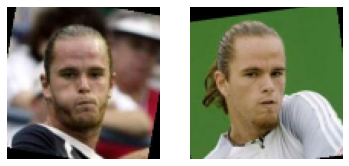

Label: 1, Dissimlarity: 0.3184


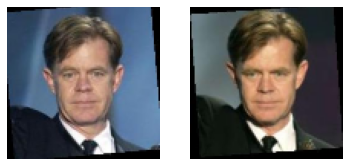

Label: 0, Dissimlarity: 0.4334


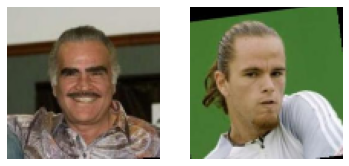

Label: 0, Dissimlarity: 0.8562


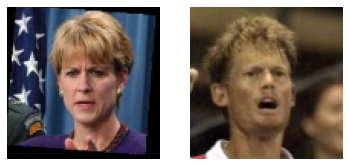

Label: 0, Dissimlarity: 0.9717


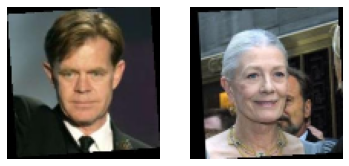

Label: 1, Dissimlarity: 1.0227


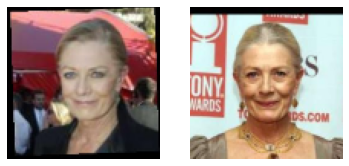

Label: 0, Dissimlarity: 0.7509


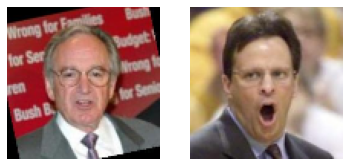

In [ ]:
# Apply the trained Siamese model to evaluate the similarity of two face images.

test_dataloader = torch.utils.data.DataLoader(test_ImageList(X1_ids_test, X2_ids_test, test_Y, all_imgs), shuffle=True, batch_size=1)

model.eval()
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        img0, img1 , label = data

        img0 = img0.to(device)
        img1 = img1.to(device)
        label = label.to(device)

        output1, output2 = model(img0, img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        print('Label: %d, Dissimlarity: %.4f' % (label.item(), euclidean_distance.item()))

        result0 = np.array(img0.squeeze().cpu()).transpose([1, 2, 0])
        result1 = np.array(img1.squeeze().cpu()).transpose([1, 2, 0])
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(result0, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        
        if (idx >5):
            break

torch.Size([1, 50]) torch.Size([1, 50])
The dissimlarity of two images is 0.8268


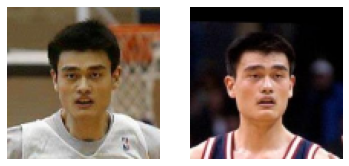

In [ ]:
# Step 1: Load images and resize images
test_image1 = cv2.imread('yao2.jpg')/255.0
test_image2 = cv2.imread('yao1.jpg')/255.0

test_image1 = cv2.resize(test_image1, (100, 100)).astype('float32')
test_image2 = cv2.resize(test_image2, (100, 100)).astype('float32')

test_image1_tensor = torch.from_numpy(np.expand_dims(np.transpose(test_image1, (2, 0, 1)),0)).to(device)
test_image2_tensor = torch.from_numpy(np.expand_dims(np.transpose(test_image2, (2, 0, 1)),0)).to(device)

# Step 2: Extract features using the pre-trained siamese model
model.eval()
with torch.no_grad():
    output1, output2 = model(test_image1_tensor, test_image2_tensor)

print(output1.shape, output2.shape)
dist = F.pairwise_distance(output1, output2)
print('The dissimlarity of two images is %.4f' % dist.item())

# Plot the two given images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Exercise 3: Apply the person verification model to find the most similar image given the query image


$\color{red}{\text{Q1. Complete the code to build an image similarity evaluation model.}}$

Tasks

- Randomly select a query image, apply the person verification model to find similar images from the data `all_imgs`
- Evaluate the similairty using the pre-trained siamese model
- Display the query image, top three similar images, and their respective confidence score.

In [ ]:
# provide your anwer to Q1 here
#
#

$\color{red}{\text{Q2. Propose how to further boost the accuracy performance of the person verification model used in this workshop.}}$

For example: Apply the face detection on the input image, then use detected face as training data, instead of using the whole image as training data.

In [ ]:
# Provide your answers to Q2 here (no need programming)
#
#
#

**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!